In [2]:
!env PYTHONPATH=src python bin/run_patchcore.py

INFO:__main__:Command line arguments: bin/run_patchcore.py
Usage: run_patchcore.py [OPTIONS] RESULTS_PATH COMMAND1 [ARGS]... [COMMAND2
                        [ARGS]...]...

Options:
  --gpu INTEGER               [default: 0]
  --seed INTEGER              [default: 0]
  --log_group TEXT
  --log_project TEXT
  --save_segmentation_images
  --save_patchcore_model
  --help                      Show this message and exit.

Commands:
  dataset
  patch_core
  sampler


In [ ]:
!pip install opencv-python

In [28]:
!find /Users/jorge/Desktop/Arbeit/IFW/milling_cutter -name '.DS_Store' -type f -delete
!find /Users/jorge/Desktop/Arbeit/IFW/10_mm_split -name '.DS_Store' -type f -delete


In [23]:
from src.patchcore.datasets.joint import JointDataset

joint_dataset = JointDataset(
    source_ifw="/Users/jorge/Desktop/Arbeit/IFW/10_mm_split",
    classname_ifw='10mm_unten',
    source_njust="/Users/jorge/Desktop/milling_cutter",
    classname_njust='front_small',
    split="train",
)

for i, data in enumerate(joint_dataset):
    if data['is_anomaly'] == 1:
        print(data)
        break
    # if i == 1:
    #     ifw_1 = data
    #     print(data)
    #     break
    if i == len(joint_dataset) - 1:
        njust_1 = data
        print(data)
        break


AttributeError: 'str' object has no attribute 'value'

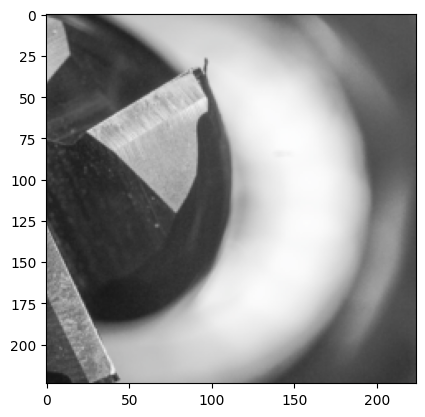

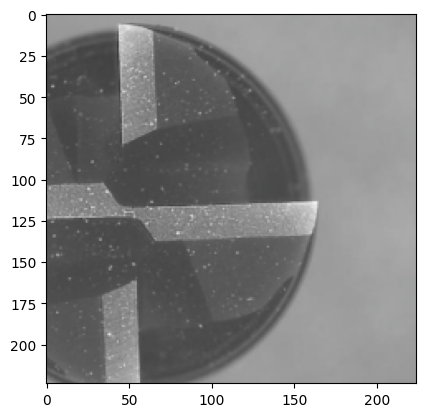

torch.Size([3, 224, 224])

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# This function will convert the tensor back to a PIL image for visualization
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor image
    img = img * IMAGENET_STD + IMAGENET_MEAN  # Unnormalize
    img = img.clip(0, 1)  # Clip to ensure it's between 0 and 1
    plt.imshow(img)
    plt.show()

# image_tensor_1 = data['image'] if isinstance(data, dict) else data

# Convert the image tensor to PIL for display
imshow(ifw_1['image'])
ifw_1['image'].shape

imshow(njust_1['image'])
njust_1['image'].shape


In [26]:
import cv2
import os
import numpy as np

TYPE = "front_large"
SPLIT = "train"
FOLDER = "good"

FOLDER_PATH = f"/Users/jorge/Desktop/Arbeit/IFW/milling_cutter/{TYPE}/{SPLIT}/{FOLDER}"
SAVE_FOLDER_PATH = f"/Users/jorge/Desktop/Arbeit/IFW/milling_cutter/{TYPE}/{SPLIT}/{FOLDER}_cropped"

# Front Small
# MIN_RADIUS = 170
# MAX_RADIUS = 300

# Front Large
MIN_RADIUS = 350
MAX_RADIUS = 450



def detect_circle(img, dp=1.5, min_dist=100, param1=100, param2=30, min_radius=0, max_radius=0):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(gray)

    blurred = cv2.GaussianBlur(contrast_enhanced, (9, 9), 2)
    # blurred = cv2.medianBlur(contrast_enhanced, 5)
    # blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Change hyperparameters, if necessary, to detect the circle
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=MIN_RADIUS, maxRadius=MAX_RADIUS)
    # gray = cv2.medianBlur(gray, 5)
    # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp, min_dist, param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0][0]
        return (x, y, r)
    return None

def center_circle(img, circle):
    x, y, r = circle
    height, width = img.shape[:2]
    center_x, center_y = width // 2, height // 2

    shift_x, shift_y = center_x - x, center_y - y
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    centered_img = cv2.warpAffine(img, M, (width, height))
    return centered_img


def crop_circle(img, circle, offset_y=0):
    x, y, r = circle
    height, width = img.shape[:2]

    # Calculate the square bounds
    x1 = max(x, 0)
    y1 = max(y - r - r*offset_y//100, 0)
    x2 = min(x + 2*r, width - 1)
    y2 = min(y + r + r*offset_y//100, height - 1)

    # Crop the image to the square
    square_cropped_img = img[y1:y2, x1:x2]

    return square_cropped_img

if __name__ == "__main__":
    if not os.path.exists(SAVE_FOLDER_PATH):
        os.makedirs(SAVE_FOLDER_PATH)

    for filename in os.listdir(FOLDER_PATH):
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):
            if not os.path.exists(f'{SAVE_FOLDER_PATH}/{filename}'):
                try:
                    image = cv2.imread(f"{FOLDER_PATH}/{filename}")
                    circle = detect_circle(image)
                    if circle:
                        # Center the circle
                        centered_image = center_circle(image, circle)
                        centered_circle = detect_circle(centered_image)

                        # Crop the image to the circle
                        cropped_circle_image = crop_circle(centered_image, centered_circle, 0)

                        # Save the images
                        cv2.imwrite(f'{SAVE_FOLDER_PATH}/{filename}', cropped_circle_image)
                        print(f"Processed and saved: {SAVE_FOLDER_PATH}/{filename}")
                except:
                    print(f"Error processing: {filename}")







# FILE_PATH = "/Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_small/train/good"
# FILE_NAME = "0291.jpg"
# SAVE_FILE_PATH = "/Users/jorge/Desktop/"


# # Load the image
# image = cv2.imread(f"{FILE_PATH}/{FILE_NAME}")

# # Detect the circle
# circle = detect_circle(image)

# if circle:
#     # Draw the circle on the original image
#     marked_image = image.copy()
#     cv2.circle(marked_image, (circle[0], circle[1]), circle[2], (0, 255, 0), 3)

#     # Center the circle
#     centered_image = center_circle(image, circle)
#     centered_circle = detect_circle(centered_image)

#     # Crop the image to the circle
#     cropped_circle_image = crop_circle(centered_image, centered_circle, 100)

#     # Save the images
#     cv2.imwrite(f'{SAVE_FILE_PATH}/marked_image.jpg', marked_image)
#     cv2.imwrite(f'{SAVE_FILE_PATH}/centered_image.jpg', centered_image)
#     cv2.imwrite(f'{SAVE_FILE_PATH}/cropped_circle_image.jpg', cropped_circle_image)





# if circle:
#     # Center the circle
#     centered_image = center_circle(image, circle)

#     # Display the result
#     cv2.imshow("Centered Circle", centered_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()



Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0515.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0416.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0206.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0188.jpg
Error processing: 0184.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0190.jpg
Error processing: 0233.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0154.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0221.jpg
Processed and saved: /Users/jorge/Desktop/Arbeit/IFW/milling_cutter/front_large/train/good_cropped/0443.jpg


In [21]:
!pip install pandas

  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 33.2 MB/s eta 0:00:0000:0100:01
Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)


## Visualization

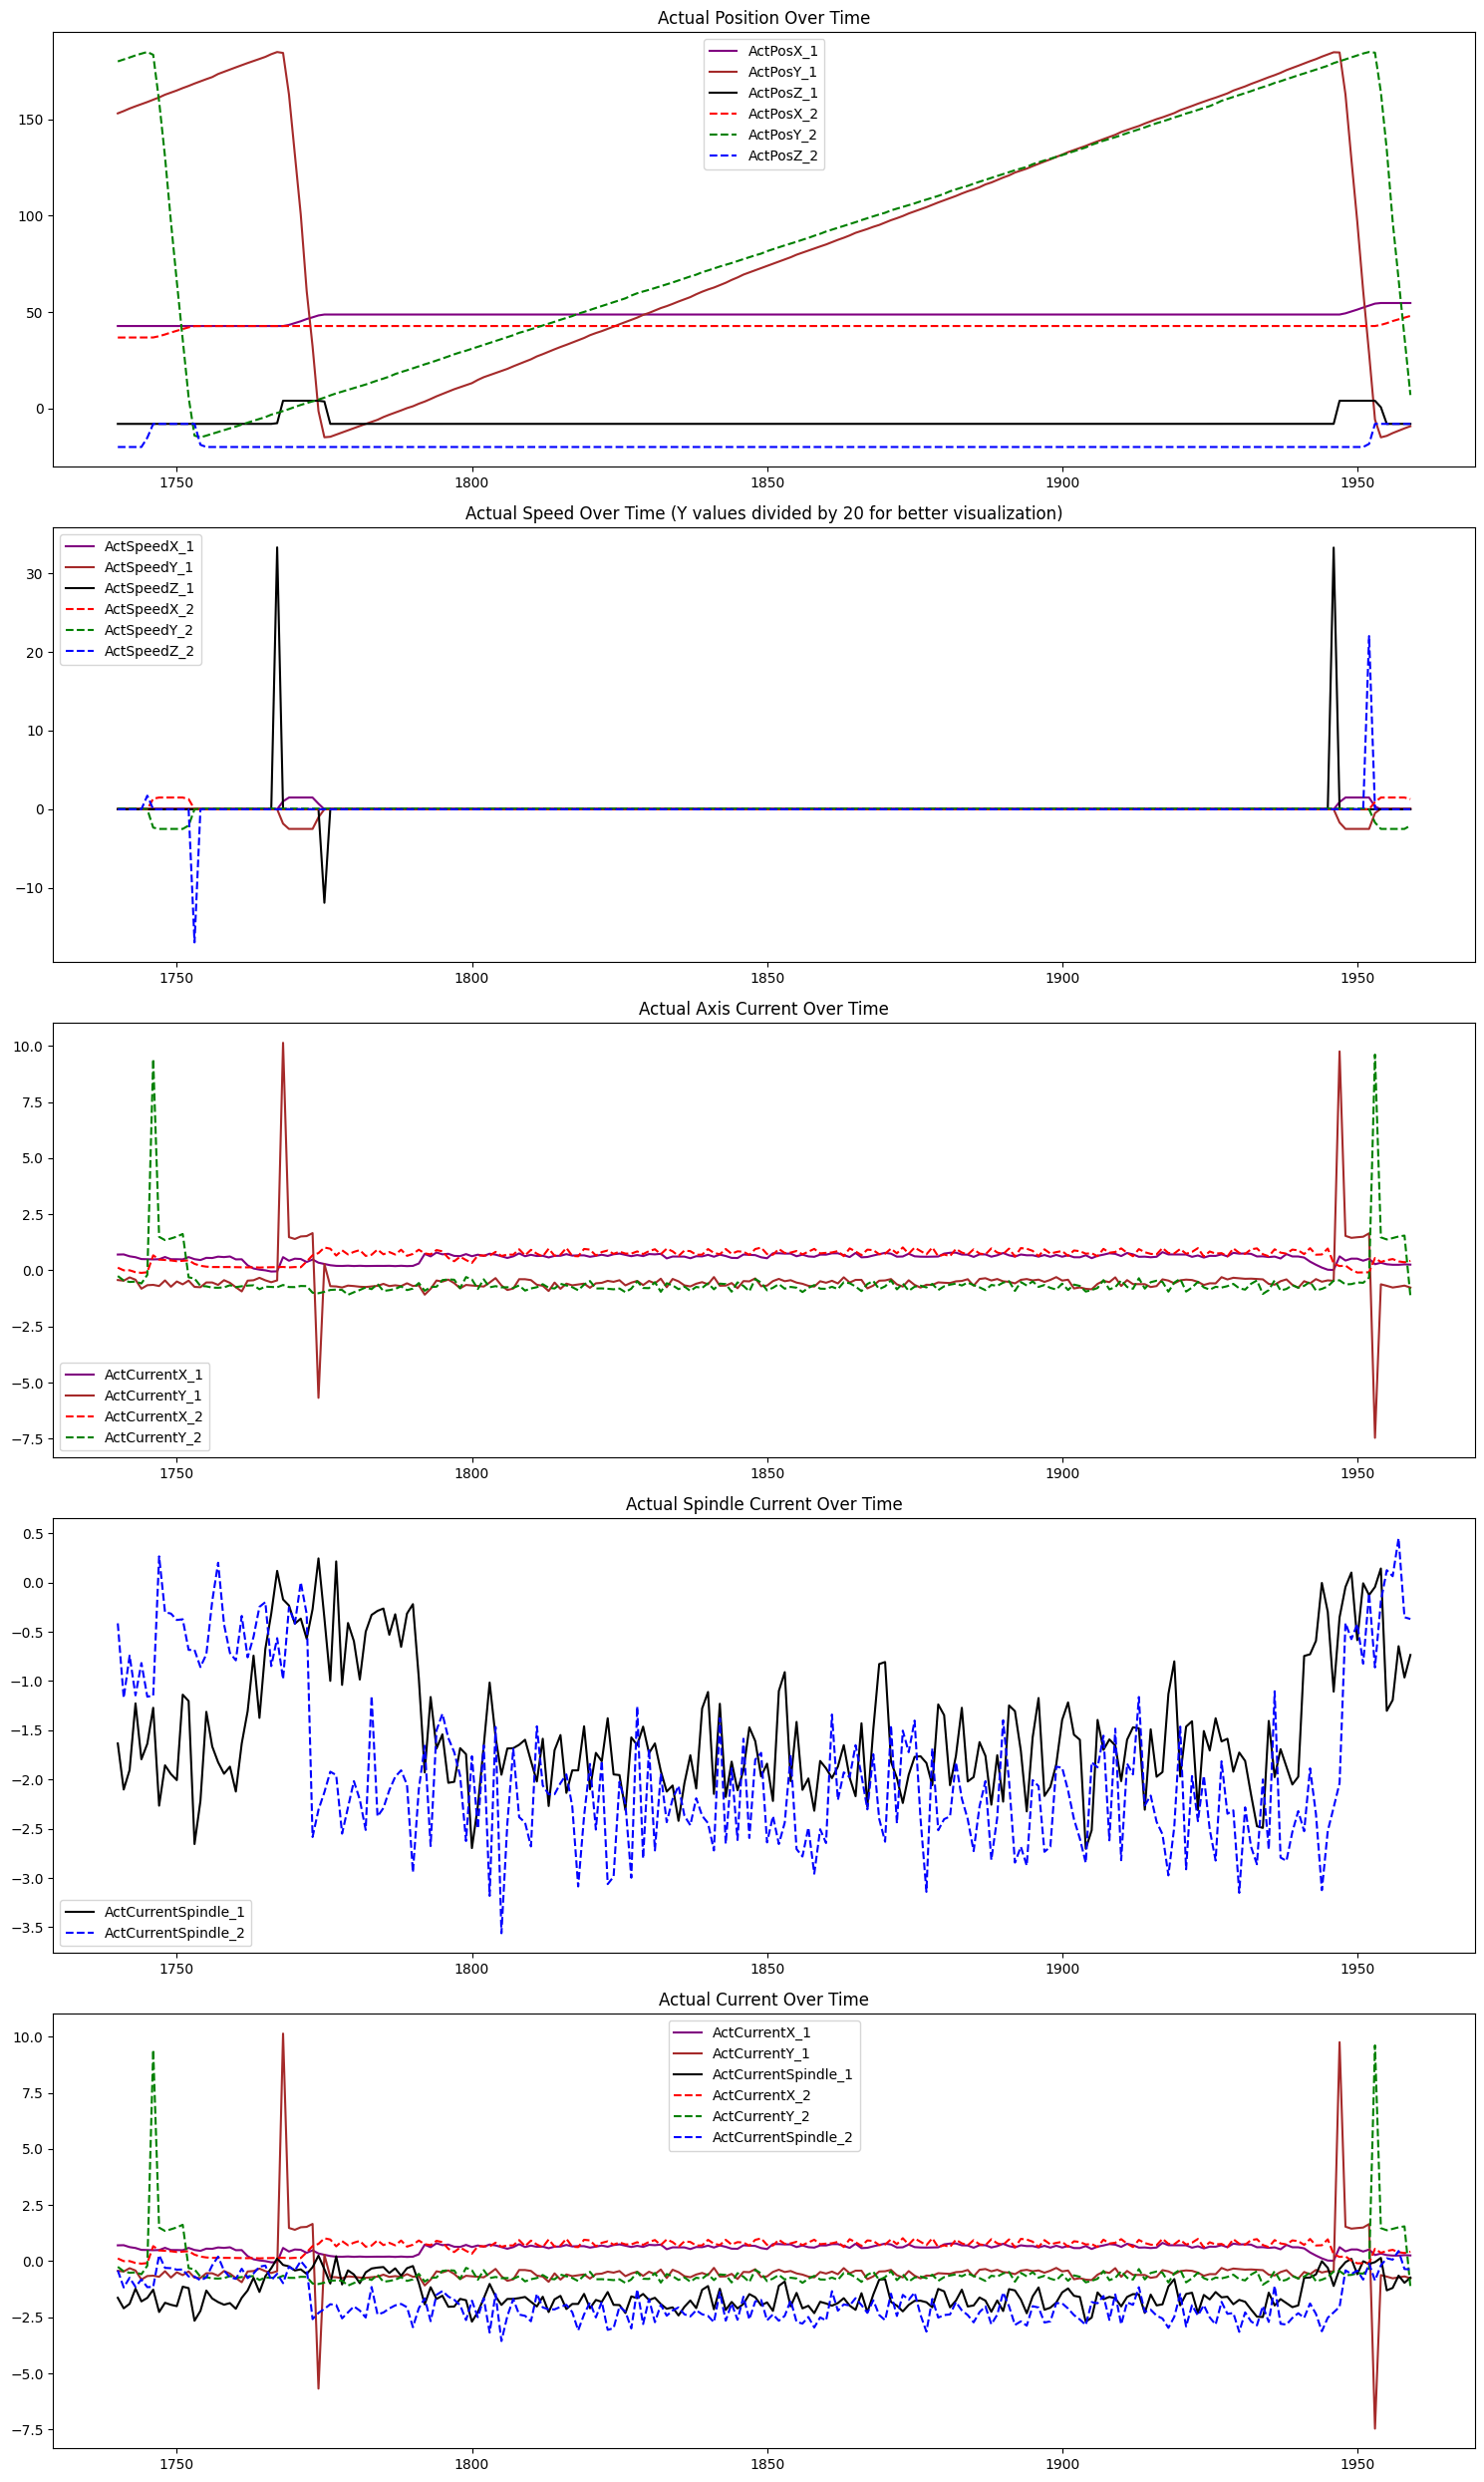

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates


file_path_1 = '~/Desktop/data_20231124-115426.csv'
# file_path_2 = '~/Desktop/data_20231124-145308.csv'
# file_path_2 = '~/Desktop/data_20231127-104614.csv'
file_path_2 = '~/Desktop/data_20231127-110020.csv'


save_path = 'plot_image.png'

start = 1740
finish = 1960
offset = 315 # Offset to align the two plots using the x position as reference

x_axis = range(start, finish)


locator = mdates.MinuteLocator()

# Load data
df_1 = pd.read_csv(file_path_1, parse_dates=['Timestamp'])
df_2 = pd.read_csv(file_path_2, parse_dates=['Timestamp'])

# Load df from 50 to avoid outliers and achieve better visualization
df_1 = df_1[start:finish]
df_2 = df_2[start-offset:finish-offset]


fig, axs = plt.subplots(5, 1, figsize=(15, 25))



# Plot the position in the first subplot
axs[0].plot(x_axis, df_1['ActPosX'], label='ActPosX_1', color='purple')
axs[0].plot(x_axis, df_1['ActPosY'], label='ActPosY_1', color='brown')
axs[0].plot(x_axis, df_1['ActPosZ'], label='ActPosZ_1', color='black')
axs[0].plot(x_axis, df_2['ActPosX'], label='ActPosX_2', color='red', linestyle='dashed')
axs[0].plot(x_axis, df_2['ActPosY'], label='ActPosY_2', color='green', linestyle='dashed')
axs[0].plot(x_axis, df_2['ActPosZ'], label='ActPosZ_2', color='blue', linestyle='dashed')
axs[0].set_title('Actual Position Over Time')
axs[0].legend()


# Plot the speed in the second subplot
axs[1].plot(x_axis, df_1['ActSpeedX'], label='ActSpeedX_1', color='purple')
axs[1].plot(x_axis, df_1['ActSpeedY']/20, label='ActSpeedY_1', color='brown')
axs[1].plot(x_axis, df_1['ActSpeedZ'], label='ActSpeedZ_1', color='black')

axs[1].plot(x_axis, df_2['ActSpeedX'], label='ActSpeedX_2', color='red', linestyle='dashed')
axs[1].plot(x_axis, df_2['ActSpeedY']/20, label='ActSpeedY_2', color='green', linestyle='dashed')
axs[1].plot(x_axis, df_2['ActSpeedZ'], label='ActSpeedZ_2', color='blue', linestyle='dashed')
axs[1].set_title('Actual Speed Over Time (Y values divided by 20 for better visualization)')
axs[1].legend()


# Plot the current in the third subplot
axs[2].plot(x_axis, df_1['ActCurrentX'], label='ActCurrentX_1', color='purple')
axs[2].plot(x_axis, df_1['ActCurrentY'], label='ActCurrentY_1', color='brown')
# axs[2].plot(x_axis, df_1['ActCurrentSpindle'], label='ActCurrentSpindle_1', color='black')
axs[2].plot(x_axis, df_2['ActCurrentX'], label='ActCurrentX_2', color='red', linestyle='dashed')
axs[2].plot(x_axis, df_2['ActCurrentY'], label='ActCurrentY_2', color='green', linestyle='dashed')
# axs[2].plot(x_axis, df_2['ActCurrentSpindle'], label='ActCurrentSpindle_2', color='blue', linestyle='dashed')
axs[2].set_title('Actual Axis Current Over Time')
axs[2].legend()

# Plot the current in the fourth subplot
axs[3].plot(x_axis, df_1['ActCurrentSpindle'], label='ActCurrentSpindle_1', color='black')
axs[3].plot(x_axis, df_2['ActCurrentSpindle'], label='ActCurrentSpindle_2', color='blue', linestyle='dashed')
axs[3].set_title('Actual Spindle Current Over Time')
axs[3].legend()

# Plot the current in the fifth subplot
axs[4].plot(x_axis, df_1['ActCurrentX'], label='ActCurrentX_1', color='purple')
axs[4].plot(x_axis, df_1['ActCurrentY'], label='ActCurrentY_1', color='brown')
axs[4].plot(x_axis, df_1['ActCurrentSpindle'], label='ActCurrentSpindle_1', color='black')
axs[4].plot(x_axis, df_2['ActCurrentX'], label='ActCurrentX_2', color='red', linestyle='dashed')
axs[4].plot(x_axis, df_2['ActCurrentY'], label='ActCurrentY_2', color='green', linestyle='dashed')
axs[4].plot(x_axis, df_2['ActCurrentSpindle'], label='ActCurrentSpindle_2', color='blue', linestyle='dashed')
axs[4].set_title('Actual Current Over Time')
axs[4].legend()


plt.tight_layout()
plt.savefig(save_path)

plt.show()


In [3]:
file_path_1 = '~/Desktop/data_20231124-115426.csv'


df_1 = pd.read_csv(file_path_1, parse_dates=['Timestamp'])
df_1.describe()

,Timestamp,ActPosX,ActPosY,ActPosZ,ActSpeedX,ActSpeedY,ActSpeedZ,ActCurrentX,ActCurrentY,ActCurrentZ,Vorschub,V_Schnitt,SchlichtTiefe,ScopeTrigger,ToolLaenge,ToolRadius,SpindelDrehzahl,SpindelDriveLoad,ActCurrentSpindle
count,5920,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.0,5920.0,5920.0,5920.0,5.920000e+03,5.920000e+03,5920.000000,5920.000000,5920.000000
mean,2023-11-24 11:48:41.761825024,85.075516,83.622748,-6.856057,0.084587,0.010998,-0.015818,0.538864,-0.500203,3.219314,0.0,0.0,0.0,1.0,1.025825e+02,4.980200e+00,3370.782214,2.699670,-1.436086
min,2023-11-24 11:42:59.017785,-183.784578,-14.983416,-8.010070,0.000000,-50.000002,-36.786798,-1.802979,-7.463135,-1.688477,0.0,0.0,0.0,1.0,1.025825e+02,4.980200e+00,0.000000,0.000000,-31.585449
25%,2023-11-24 11:45:48.918060032,36.819670,35.038640,-8.001393,0.000000,1.666667,0.000000,0.422974,-0.693848,3.101807,0.0,0.0,0.0,1.0,1.025825e+02,4.980200e+00,3499.145508,1.190186,-1.955933
50%,2023-11-24 11:48:41.801711872,84.553265,79.709060,-7.999980,0.000000,1.666667,0.000000,0.618652,-0.579346,3.175293,0.0,0.0,0.0,1.0,1.025825e+02,4.980200e+00,3499.832153,2.511597,-1.650879
75%,2023-11-24 11:51:33.483571968,132.286903,132.956305,-7.998160,0.000000,1.666667,0.000000,0.697266,-0.463135,3.300049,0.0,0.0,0.0,1.0,1.025825e+02,4.980200e+00,3500.518799,3.869629,-0.929688
max,2023-11-24 11:54:26.430550,180.020008,185.001735,195.250920,30.000001,2.000000,46.666669,1.932861,10.294922,8.700439,0.0,0.0,0.0,1.0,1.025825e+02,4.980200e+00,3505.783081,100.000000,8.582520
std,NaN,56.967041,57.682409,10.623756,1.063800,8.594444,2.600084,0.221508,0.694556,0.362954,0.0,0.0,0.0,0.0,1.421206e-14,8.882534e-16,659.253192,2.403788,0.859244


In [8]:
df_1.index

RangeIndex(start=50, stop=5920, step=1)

In [9]:
df_2.index


RangeIndex(start=50, stop=5583, step=1)